In [1]:
import pathlib

import anndata
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from ALLCools.integration import calculate_overlap_score, confusion_matrix_clustering

from ALLCools.mcds import MCDS
from ALLCools.plot import *
from wmb import cemba_atac, brain, cemba

In [2]:
mc_cat_key = "L4Region"
atac_cat_key = "L4"

In [3]:
# Parameters
atac_cat_key = "L4"
cpu = 1
group_name = "TH"
mc_cat_key = "L4Region"
mem_gb = 1


## Load

In [4]:
mc_annot = cemba.get_mc_annot()

L4_annot does not exist in data_vars or coords, palette not added.


In [5]:
atac_annot = cemba_atac.get_atac_annot()

In [6]:
mc_cluster = mc_annot[mc_cat_key].to_pandas()
atac_cluster = atac_annot[atac_cat_key].to_pandas()

In [7]:
adata_merge = anndata.read_h5ad("final_with_coords.h5ad")

In [8]:
adata_merge

AnnData object with n_obs × n_vars = 594767 × 299329
    obs: 'read_count', 'Modality', 'L4Region', 'DissectionRegion', 'leiden'
    var: 'chrom', 'end', 'start'
    uns: 'leiden', 'leiden_sizes', 'neighbors', 'paga', 'umap'
    obsm: 'X_harmony', 'X_lsi_integrate', 'X_tsne', 'X_umap'
    obsp: 'connectivities', 'distances'

In [9]:
atac_meta = adata_merge.obs[adata_merge.obs["Modality"] == "ATAC"].copy()
mc_meta = adata_merge.obs[adata_merge.obs["Modality"] == "mC"].copy()

## Confusion Matrix Based On Co-clustering Overlap Score

In [10]:
atac_meta[atac_cat_key] = atac_annot[atac_cat_key].to_pandas()
mc_meta[mc_cat_key] = mc_annot[mc_cat_key].to_pandas()
os_mat = calculate_overlap_score(
    atac_meta[['leiden', "leiden"]], mc_meta[[mc_cat_key, "leiden"]]
)
#os_mat.to_hdf(f"atac-{atac_cat_key}.mC-{mc_cat_key}.overlap_score.hdf", key="data")

## Confusion Matrix Clustering

In [11]:
(
    query_group,
    ref_group,
    confusion_matrix,
    g,
    modularity_score,
) = confusion_matrix_clustering(
    confusion_matrix=os_mat,
    min_value=0.1,
    max_value=0.9,
    partition_type=None,
    resolution=0.5,
    seed=0,
)
print(f"Modularity: {modularity_score:.3f}")

Modularity: 0.916


<AxesSubplot:>

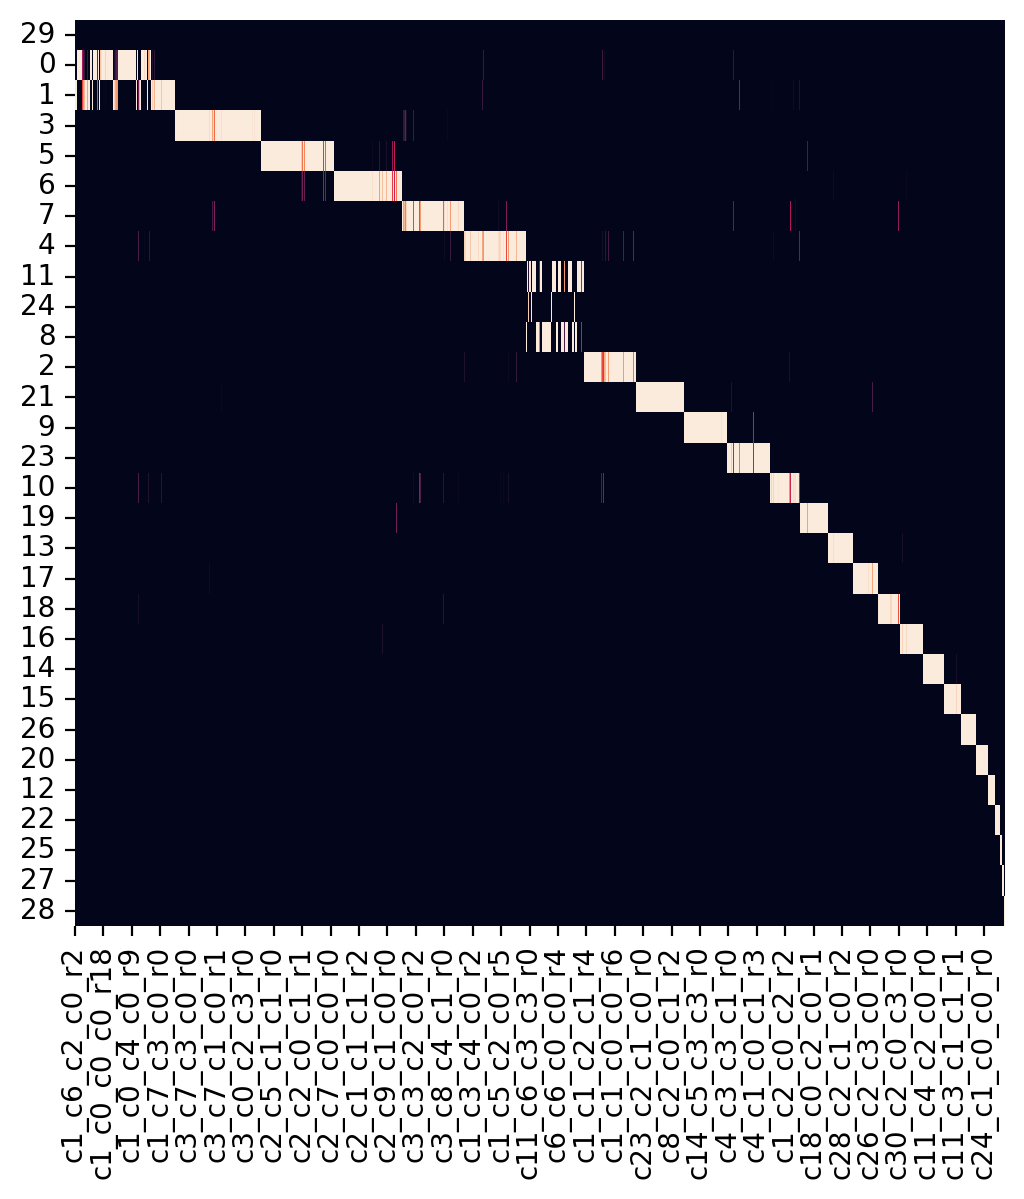

In [12]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=200)
sns.heatmap(confusion_matrix, ax=ax, vmin=0.1, vmax=0.9, cbar=None)

In [13]:
# combine query into ref groups, ref is non-dup, query maybe dup
integration_groups = {}
for group in ref_group.unique():
    integration_groups[group] = {
        "ref": ref_group[ref_group == group].index.tolist(),
        "query": query_group[query_group == group].index.tolist(),
    }

In [14]:
for group, group_dict in integration_groups.items():
    print(group)
    print(f'ref: {", ".join(group_dict["ref"])}')
    print(f'query: {", ".join(group_dict["query"])}')
    print()

15
ref: c0_c0_c19_c0_r0, c30_c0_c0_c0_r0, c30_c0_c0_c0_r1, c30_c0_c0_c0_r2, c30_c0_c0_c1_r0, c30_c0_c0_c1_r1, c30_c0_c0_c2_r0, c30_c0_c1_c0_r0, c30_c0_c1_c0_r1, c30_c0_c1_c0_r2, c30_c0_c1_c0_r3, c30_c0_c1_c1_r0, c30_c0_c1_c1_r1, c30_c0_c2_c0_r0, c30_c0_c2_c0_r1, c30_c0_c2_c0_r2, c30_c0_c2_c0_r3, c30_c2_c0_c0_r0, c30_c2_c0_c0_r1, c30_c2_c0_c0_r2, c30_c2_c0_c1_r0, c30_c2_c0_c1_r1, c30_c2_c0_c2_r0, c30_c2_c0_c3_r0, c30_c2_c1_c0_r0, c30_c2_c1_c0_r1, c30_c2_c1_c1_r0, c30_c2_c1_c2_r0, c30_c3_c0_c0_r0, c30_c3_c0_c0_r1, c30_c3_c0_c0_r2, c30_c3_c0_c1_r0, c30_c3_c1_c0_r0, c30_c3_c1_c0_r1, c30_c3_c2_c0_r0, c30_c3_c2_c0_r1, c30_c3_c3_c0_r0, c30_c3_c3_c0_r1, c30_c4_c0_c0_r0, c30_c4_c0_c0_r1, c30_c4_c1_c1_r0, c30_c4_c2_c2_r0
query: 18

6
ref: c0_c0_c1_c1_r0, c0_c1_c3_c1_r1, c11_c6_c3_c3_r0, c20_c0_c1_c2_r0, c20_c1_c0_c0_r1, c20_c9_c0_c0_r0, c6_c0_c0_c0_r0, c6_c0_c0_c0_r1, c6_c0_c0_c0_r2, c6_c0_c0_c0_r3, c6_c0_c0_c1_r0, c6_c0_c0_c2_r0, c6_c0_c1_c0_r0, c6_c0_c1_c0_r1, c6_c0_c1_c0_r2, c6_c0_c1_c0_r3, c

15
6
8
18
17
19
9
23
12
2
0
4
11
13
7
5
1
21
20
24
14
10
3
16
22
25


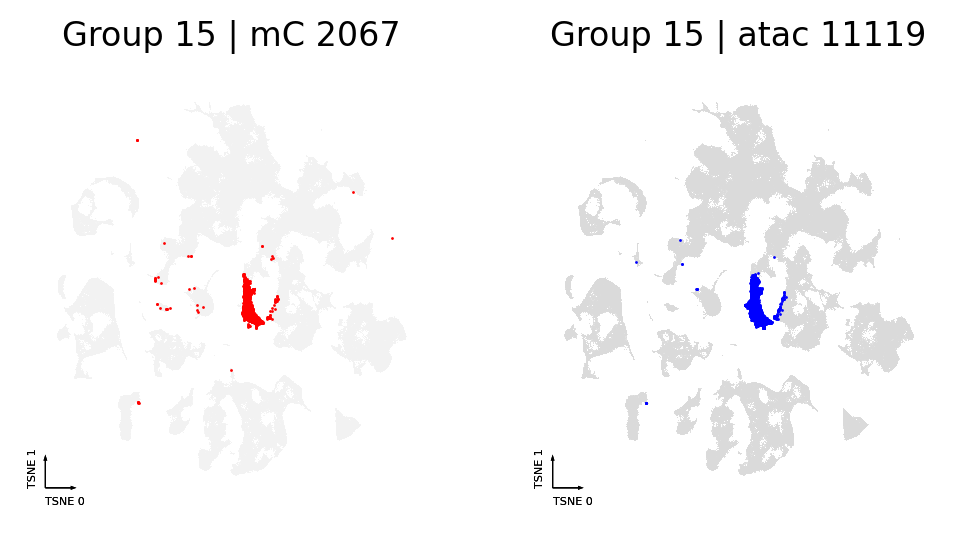

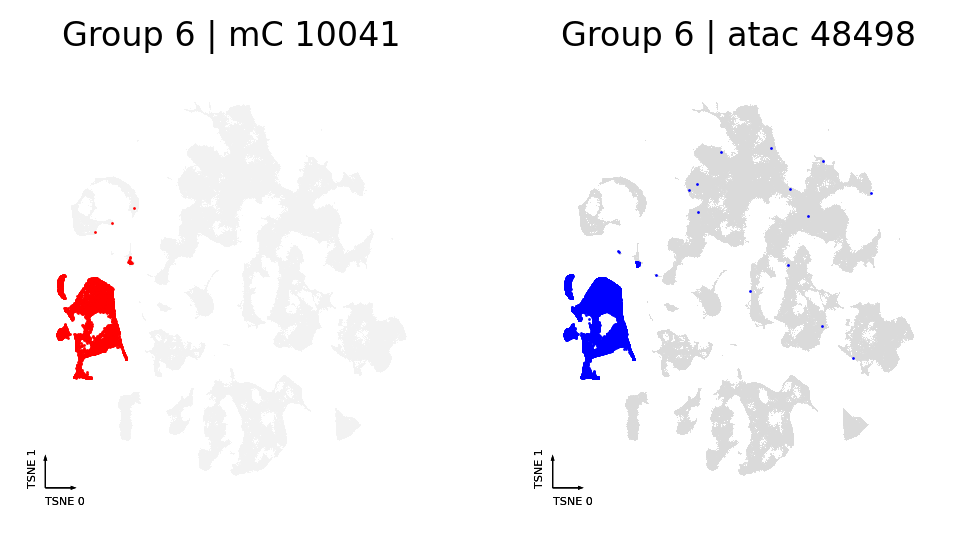

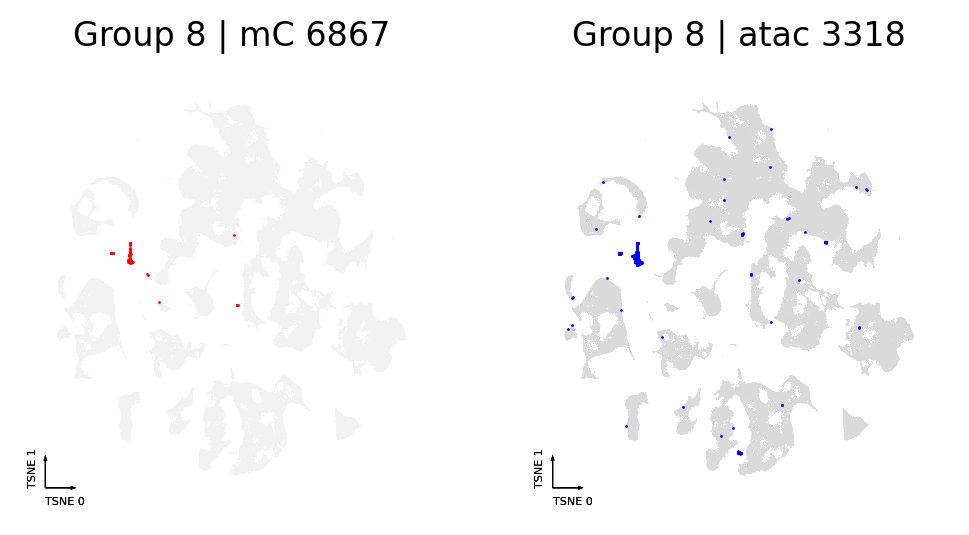

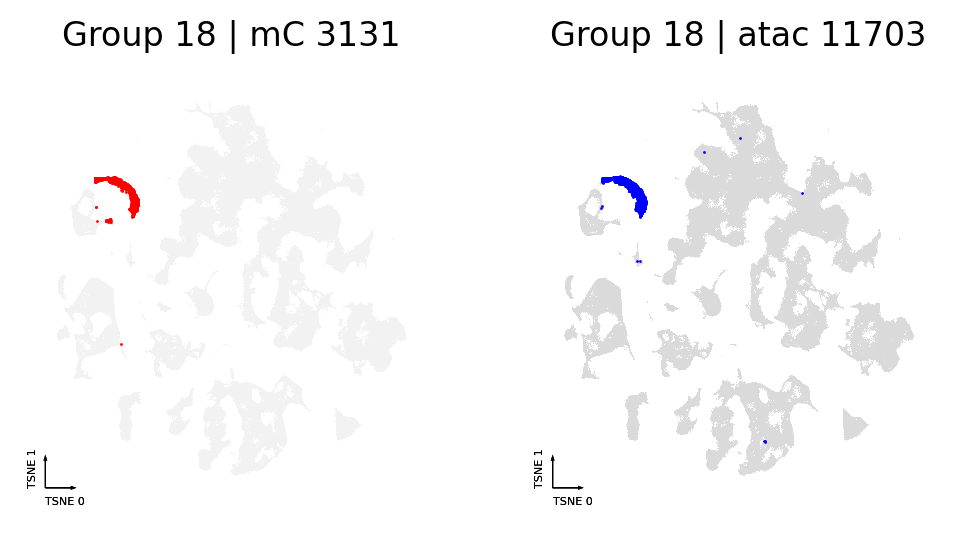

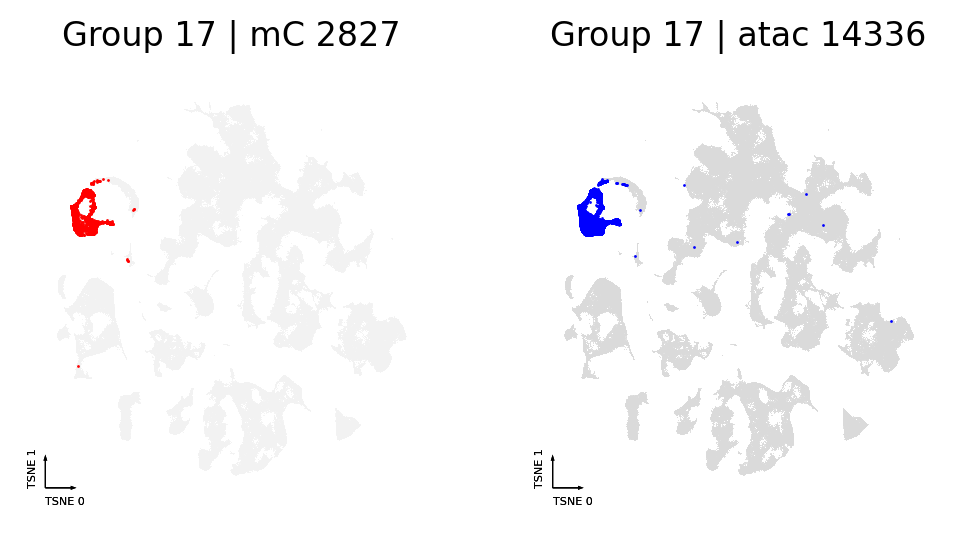

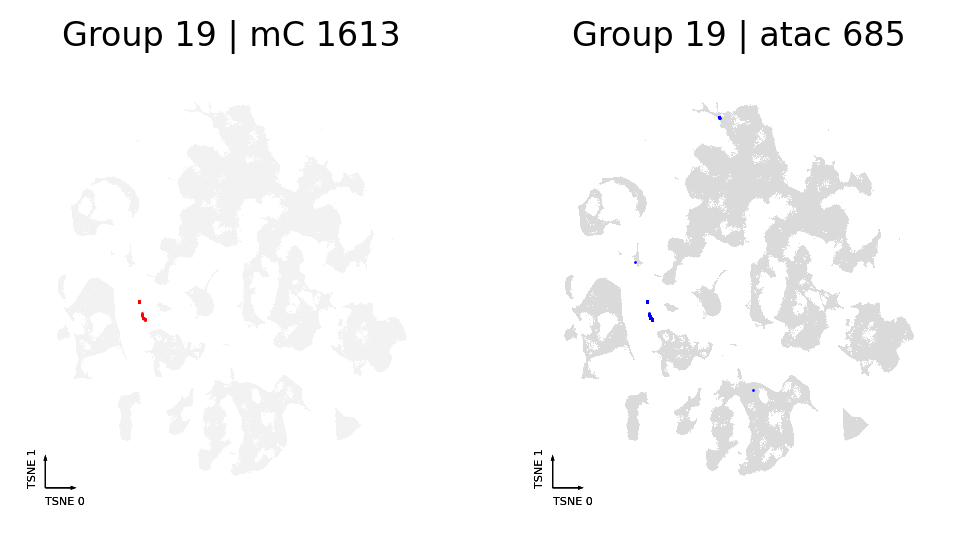

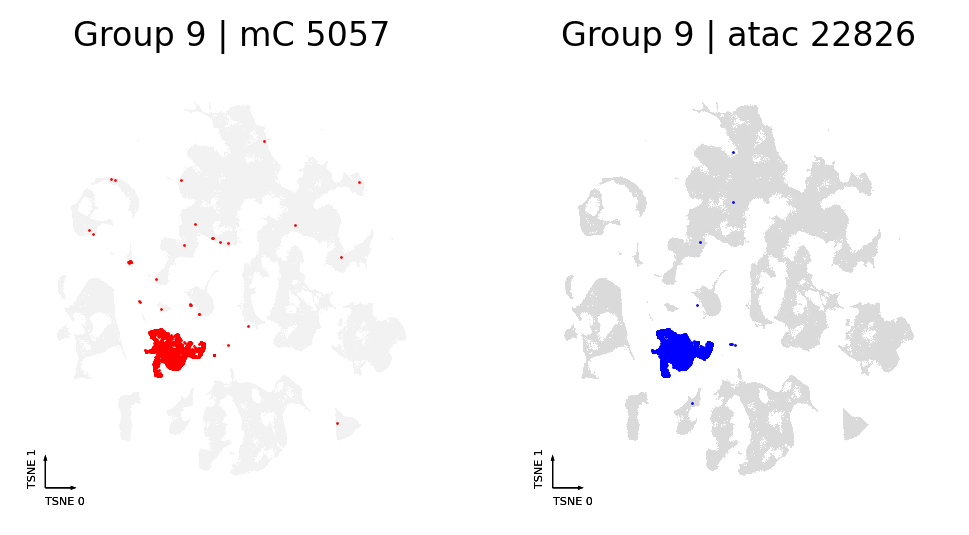

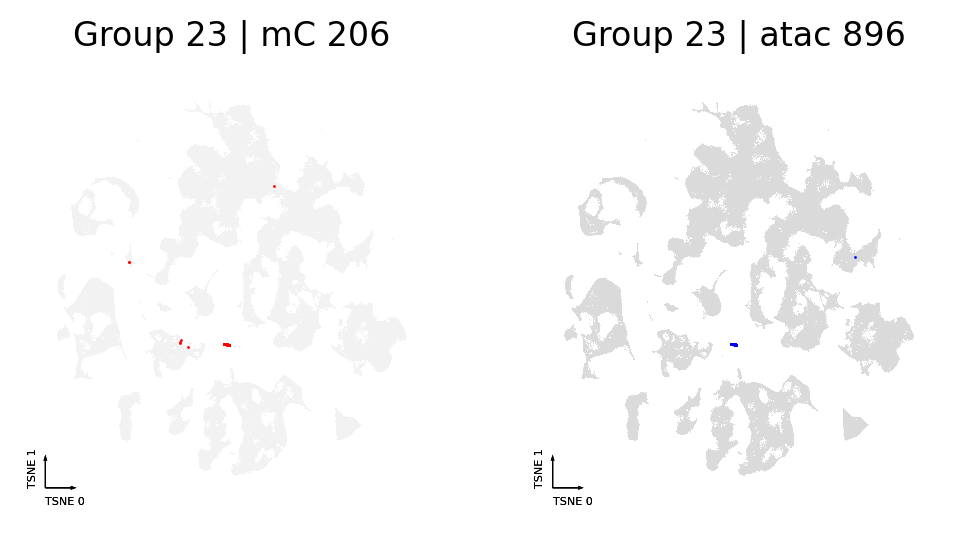

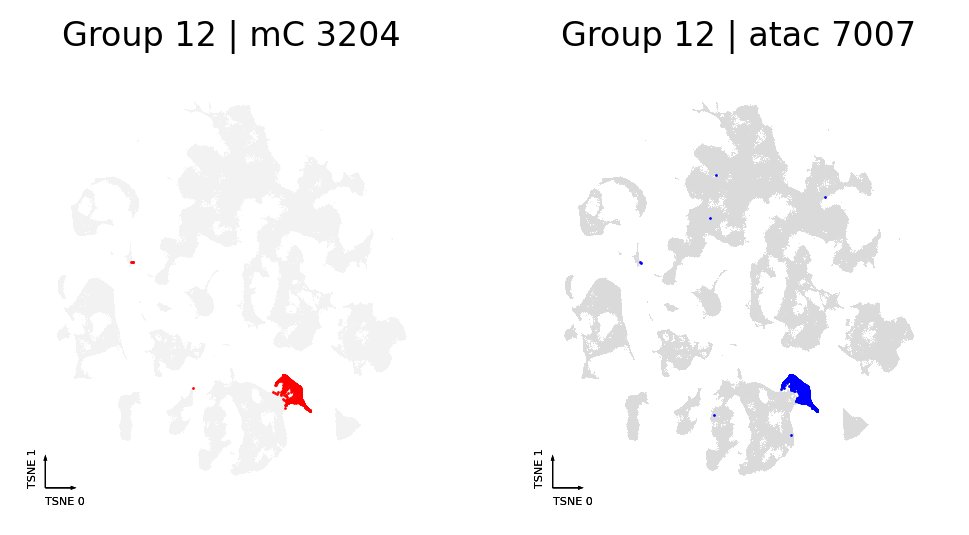

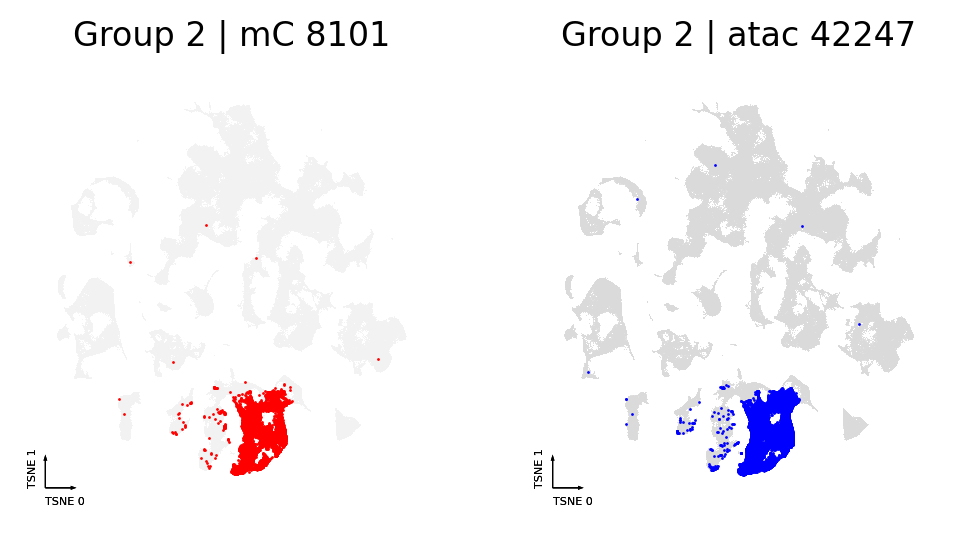

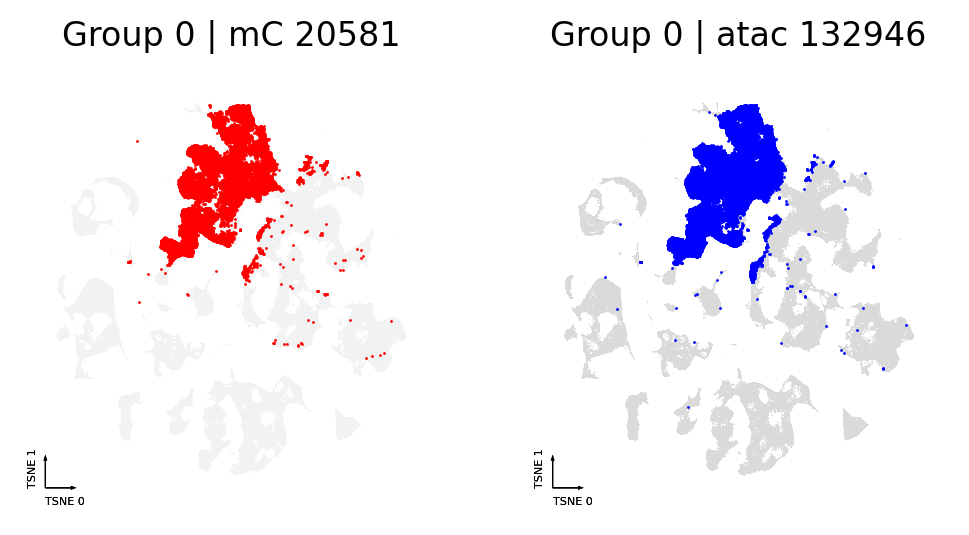

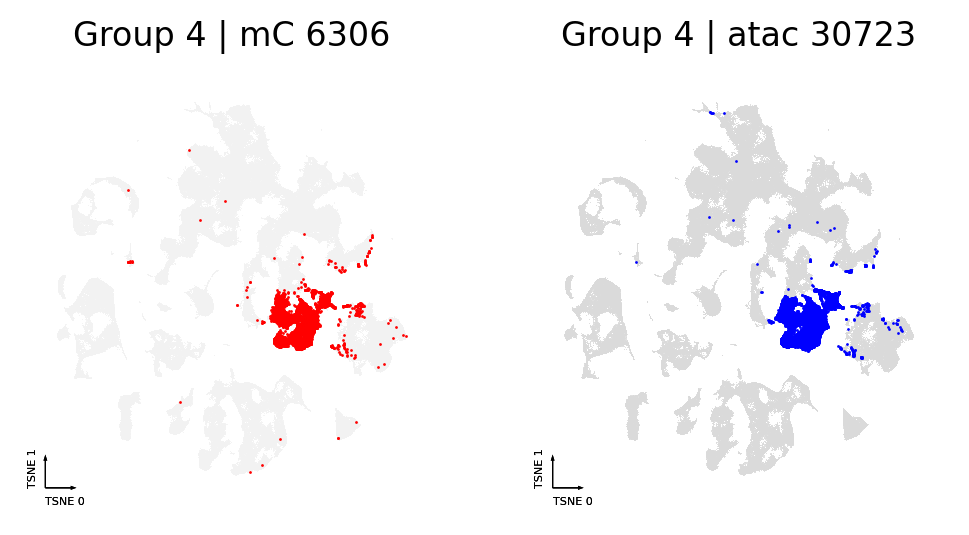

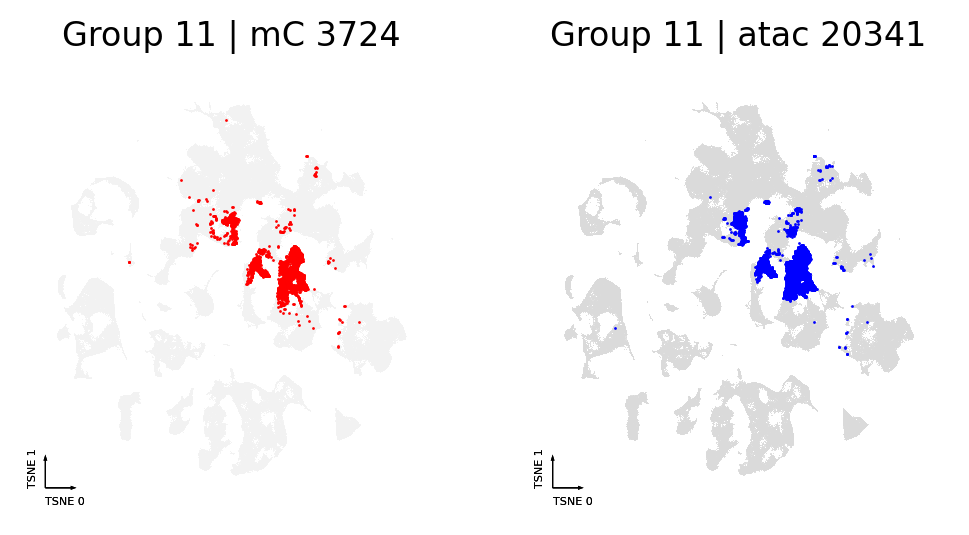

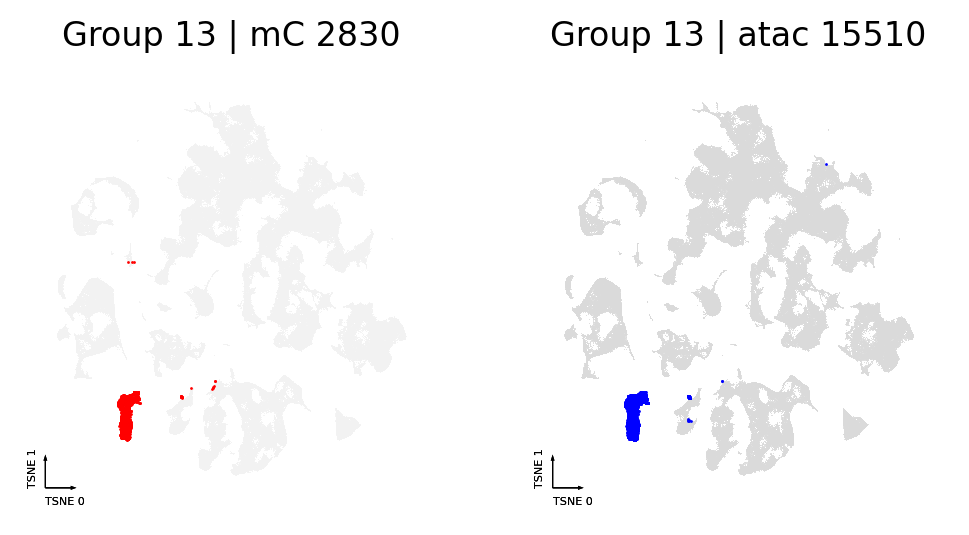

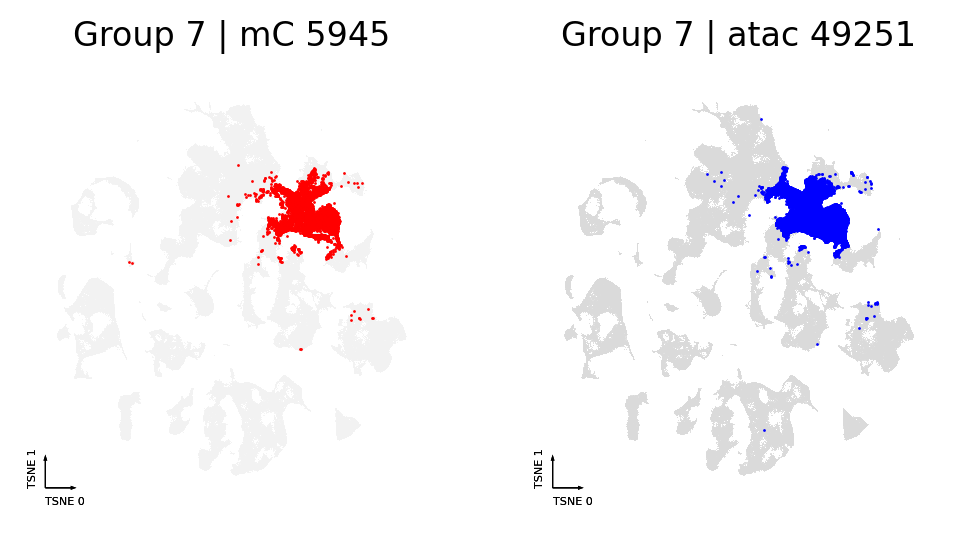

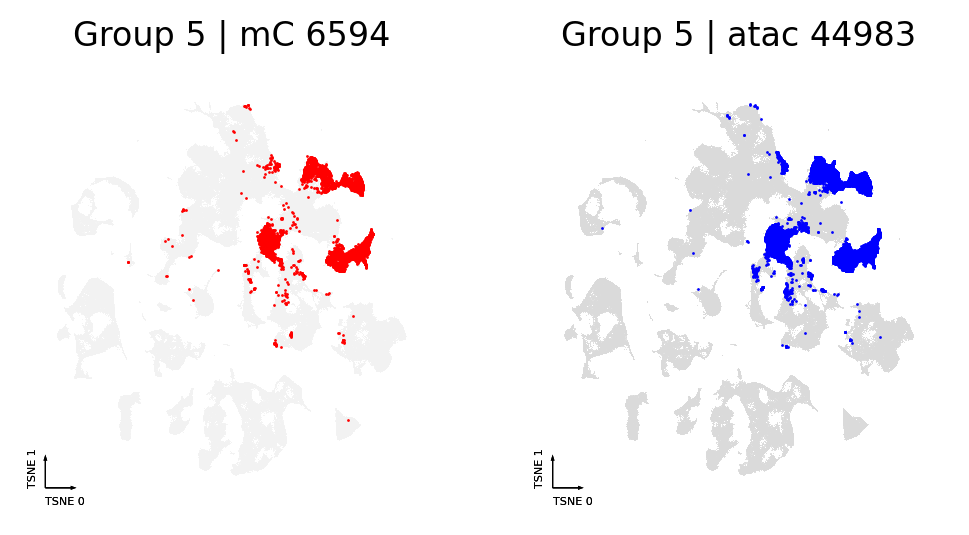

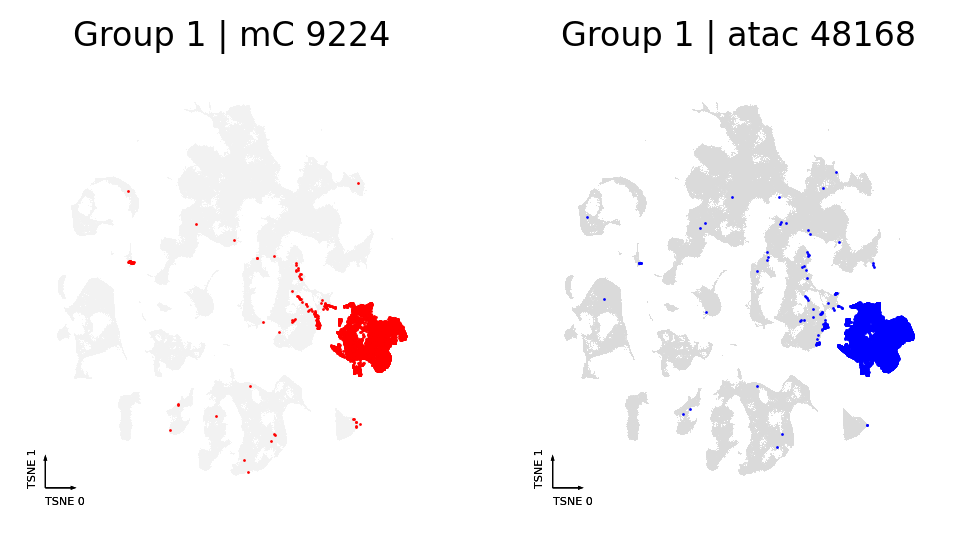

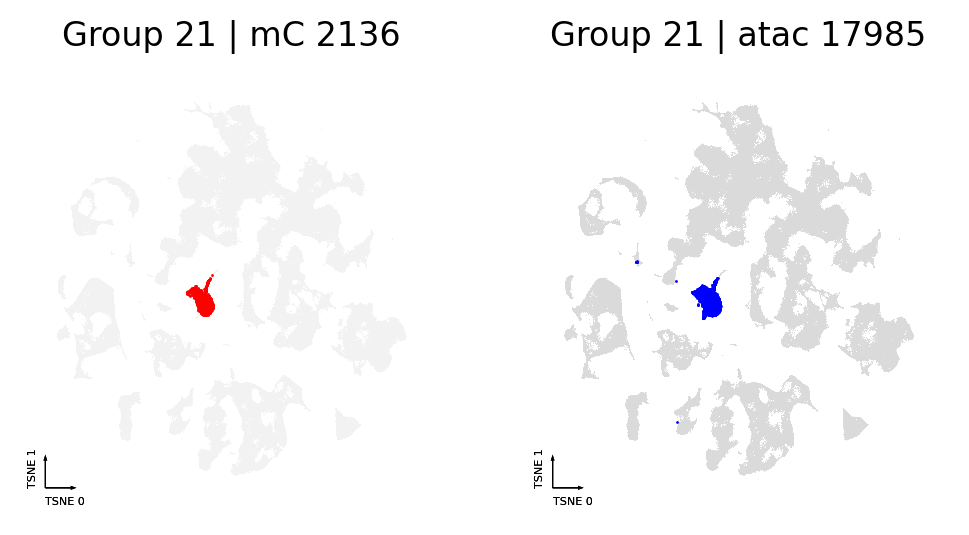

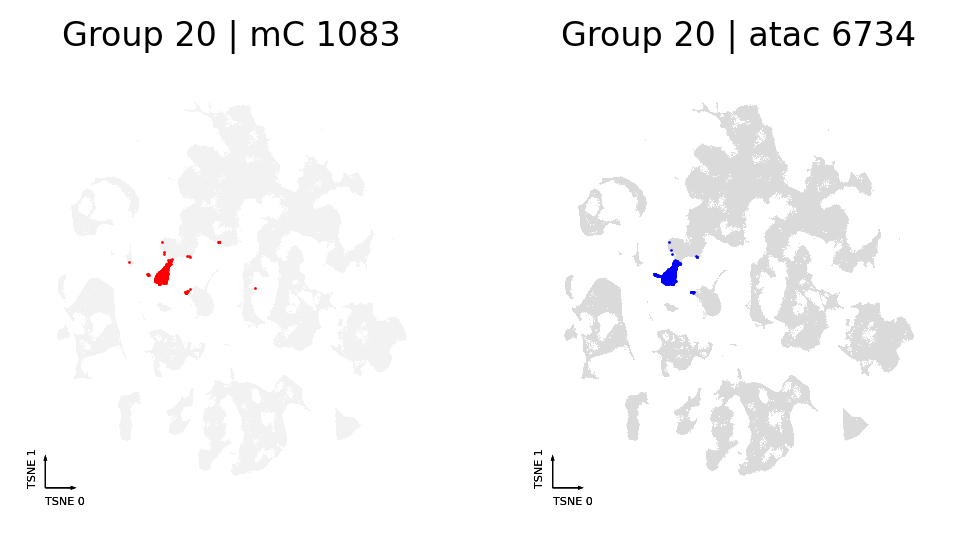

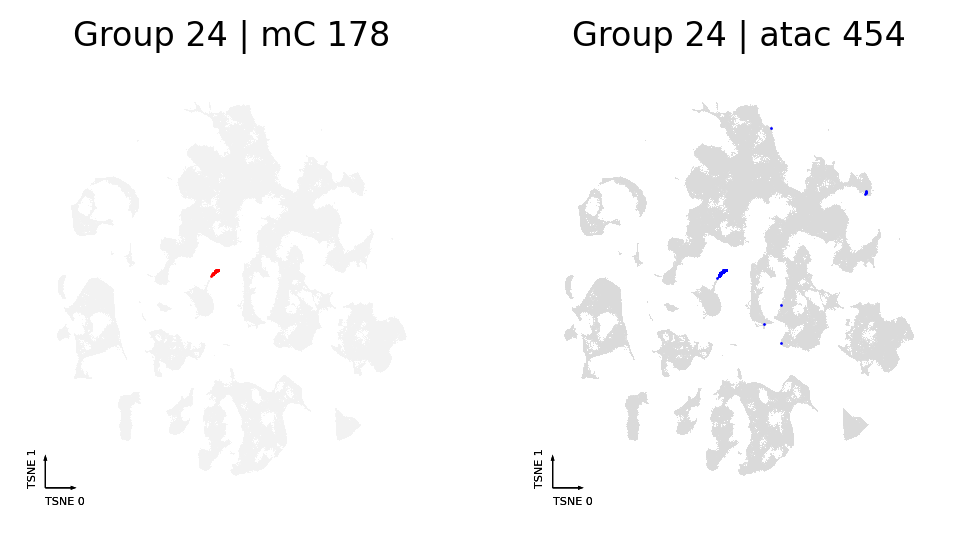

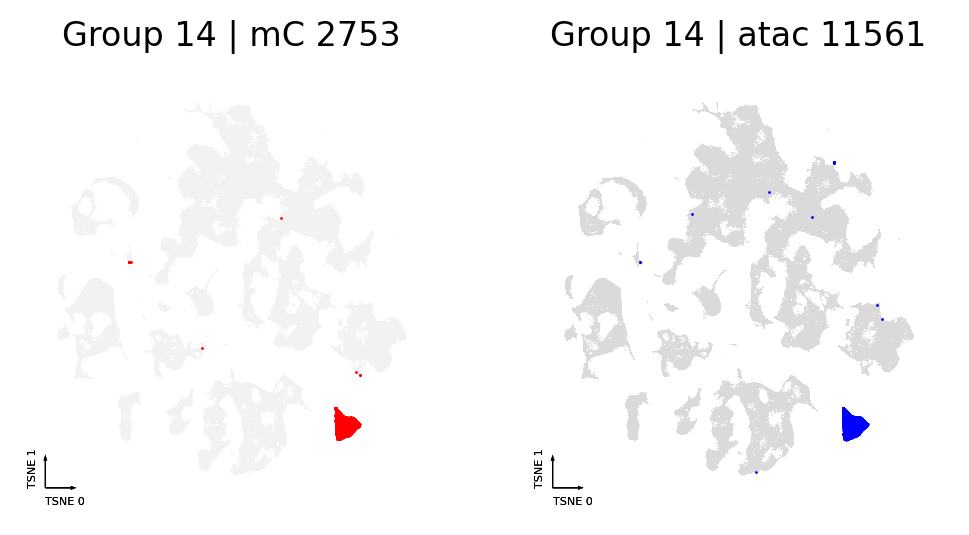

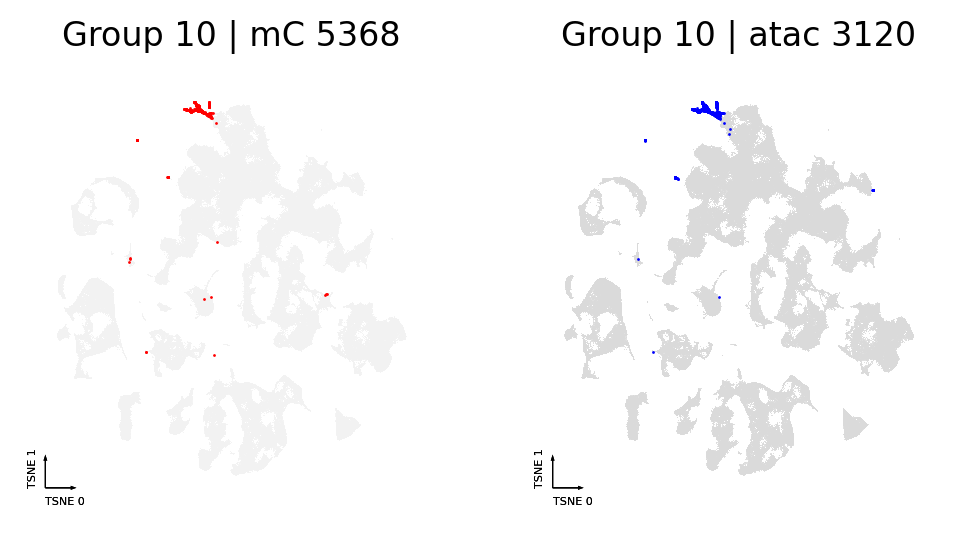

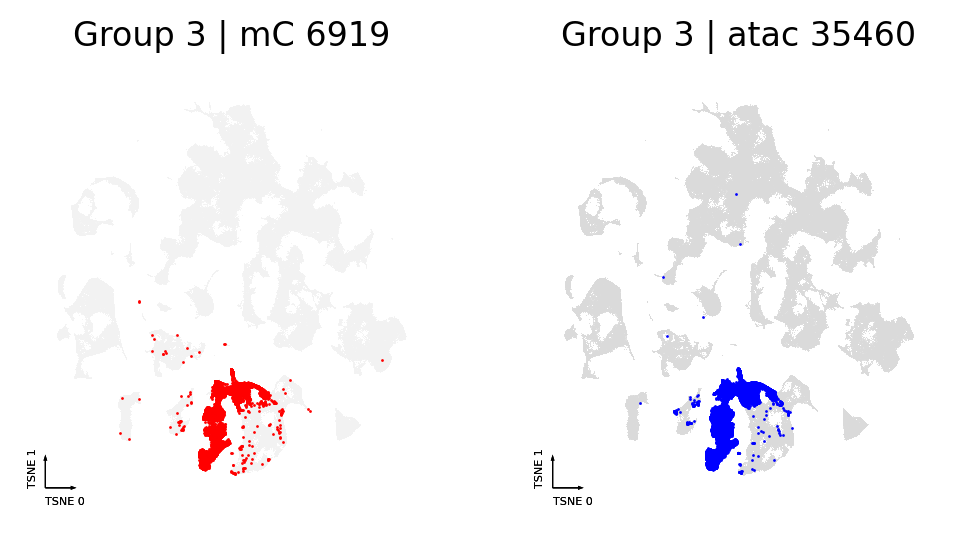

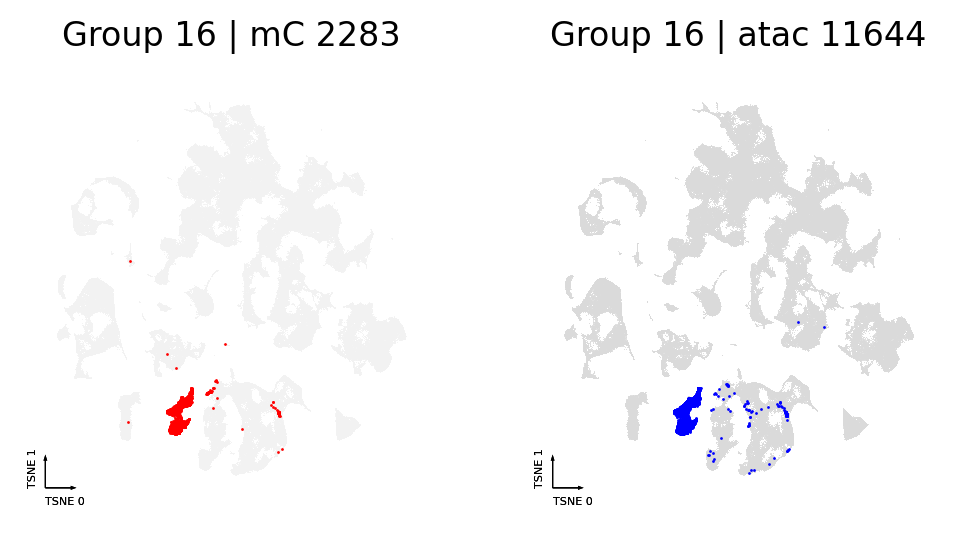

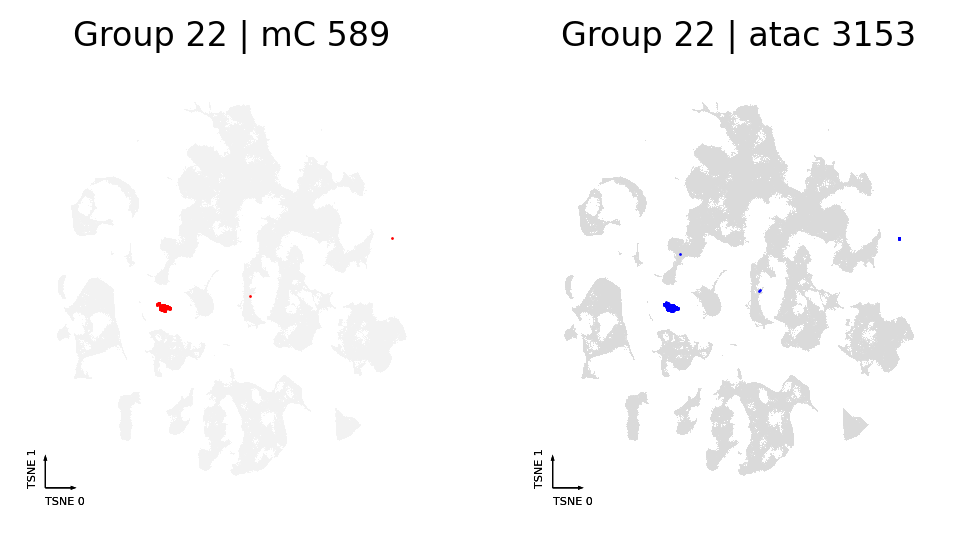

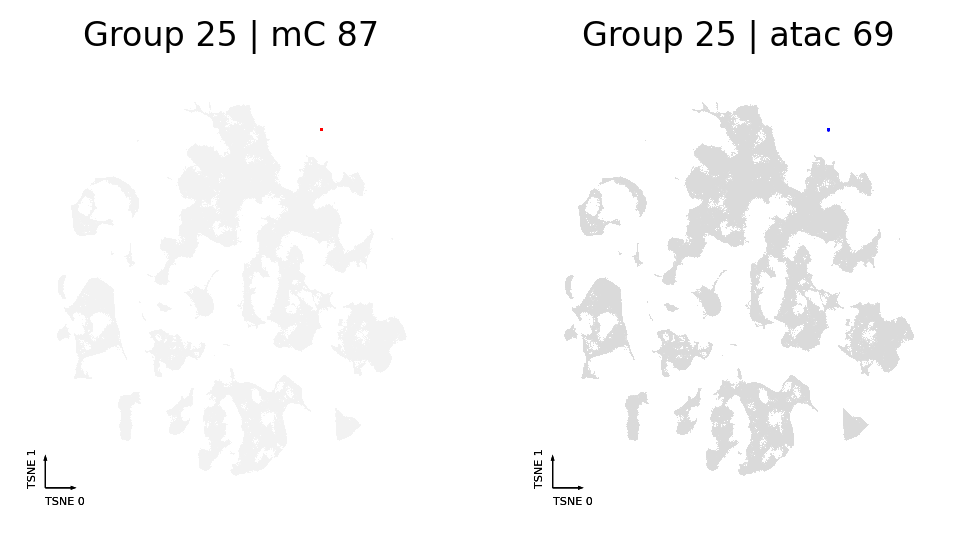

In [15]:
import matplotlib.backends.backend_pdf

adata = anndata.read_h5ad('final_with_coords.h5ad')

pdf = matplotlib.backends.backend_pdf.PdfPages("L3.integration_groups.pdf")

for i, (group, cluster_dict) in enumerate(integration_groups.items()):
    print(group)
    fig, axes = plt.subplots(
        figsize=(6, 3),
        nrows=1,
        ncols=2,
        dpi=200,
    )

    mc_cells = adata.obs["Modality"] == "mC"
    atac_cells = adata.obs["Modality"] == "ATAC"
    use_mc_cells = mc_cluster[mc_cluster.isin(cluster_dict["ref"])].index
    # use_atac_cells = atac_cluster[atac_cluster.isin(cluster_dict["query"])].index
    use_atac_cells = adata.obs_names[adata.obs['leiden'].isin(cluster_dict['query'])]

    ax = axes[0]
    categorical_scatter(
        ax=ax, data=adata, coord_base="tsne", color="lightgrey", max_points=None
    )
    categorical_scatter(
        ax=ax,
        s=1,
        data=adata[adata.obs_names.isin(use_mc_cells)],
        coord_base="tsne",
        color="red",
    )
    ax.set(title=f"Group {group} | mC {use_mc_cells.size}")
    ax = axes[1]
    categorical_scatter(
        ax=ax, data=adata[atac_cells], coord_base="tsne", color="grey", max_points=None
    )
    categorical_scatter(
        ax=ax,
        s=1,
        data=adata[adata.obs_names.isin(use_atac_cells)],
        coord_base="tsne",
        color="blue",
    )
    ax.set(title=f"Group {group} | atac {use_atac_cells.size}")
    
    pdf.savefig(fig)
pdf.close()


In [16]:
import joblib

joblib.dump(integration_groups, f'atac-CoCluster.mc-{mc_cat_key}.integration_groups.dict')

['atac-CoCluster.mc-L4Region.integration_groups.dict']